In [ ]:
import torch
import matplotlib.pyplot as plt
import copy
from score_models import VE, VP
from dataclasses import dataclass
from torch import distributions

import numpy as np
import torch.nn as nn
from scipy.stats import norm

from torch import Tensor
from scipy.spatial import Voronoi, voronoi_plot_2d

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    'font.size': 18,
})

# Set parameters
device = torch.device('cpu')

# set seed
torch.manual_seed(0)
np.random.seed(1)

## Define Data

<Figure size 200x200 with 0 Axes>

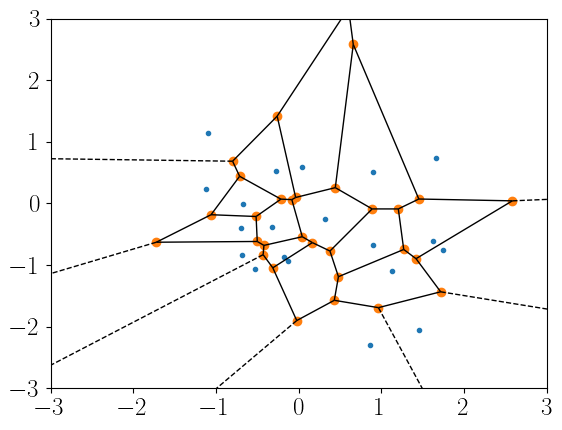

In [25]:
N    = 20
dim  = 2
data = np.random.randn(N,dim)

# define voronoi tesselation
vor = Voronoi(data)

# plot
plt.figure(figsize=(2,2))
fig = voronoi_plot_2d(vor)
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()

## Define models

In [26]:
from score_models import VE, VP
model = VE()
model.eps = 0.

In [ ]:
from score_models import GMM_score_regularized
# define GMM
gmm_train = GMM_score_regularized(torch.tensor(data, dtype=torch.float32), model.marginal_prob_mean, model.marginal_prob_std, constant=0.1)

# test network
dim = data.shape[1]
rand_x = torch.randn(1000, dim).to(device)
rand_t = torch.rand(1,) * torch.ones((1000,1))
print(gmm_train(rand_x, rand_t[:,0]).shape)

torch.Size([1000, 2])


## Compute model weights

In [40]:
from scipy import integrate

def ode_sampler(score_net, model, latents):
    
    # define initial samples
    init_T = model.T * torch.ones(batch_size, device=latents.device)
    init_x = latents * model.marginal_prob_std(init_T)[:, None]
    
    def score_eval_wrapper(sample, time_steps):
        """A wrapper of the score-based model for use by the ODE solver."""
        sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(latents.shape)
        with torch.no_grad():    
            score = score_net(sample, time_steps)
        return score
    
    def ode_func(t, x):        
        """The ODE function for use by the ODE solver."""
        batch_time = torch.ones(batch_size, device=latents.device) * t
        g = model.diffusion_coeff(batch_time)
        f = model.drift(x.reshape(latents.shape), batch_time)
        rhs = f - 0.5*(g**2)[:,None] * score_eval_wrapper(x, batch_time)
        return rhs.detach().numpy().reshape((-1,)).astype(np.float64)
    
    # Run the black-box ODE solver
    err_tol = 1e-5
    res = integrate.solve_ivp(ode_func, (model.T, model.eps), init_x.reshape(-1).cpu().numpy(), rtol=err_tol, atol=err_tol, method='RK45', dense_output=True)  
    return (res.t, res.y)

<Figure size 640x480 with 0 Axes>

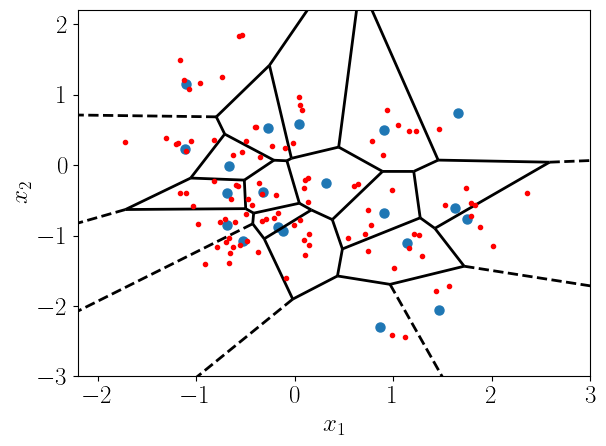

<Figure size 640x480 with 0 Axes>

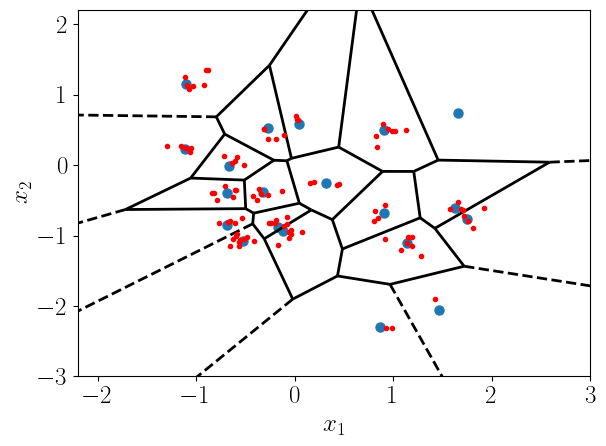

In [46]:
# define latent samples
batch_size = 100
latents = torch.randn(batch_size, dim).to(device)

constant_vect = [0.1,0.01]

for const in constant_vect:

    # define GMM
    gmm_train = GMM_score(torch.tensor(data, dtype=torch.float32), model.marginal_prob_mean, model.marginal_prob_std, constant=const)

    # evaluate ODE and SDE paths
    GMM_t, GMM_x = ode_sampler(gmm_train, model, latents)

    # extract final points of each sequence
    lat_shape = [batch_size, 2, len(GMM_t)]
    final_pts = GMM_x.reshape(lat_shape)[:,:,-1]

    # plot results
    plt.figure()
    fig = voronoi_plot_2d(vor, show_vertices=False, line_width=2, point_size=13)
    plt.plot(final_pts[:,0], final_pts[:,1], '.r')#marker_size=12)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.xlim(-2.2,3)
    plt.ylim(-3,2.2)
    plt.tight_layout()
    plt.savefig('ODE_trajectory_regularized_const_'+str(const)+'.pdf')

### Plot ODE weights

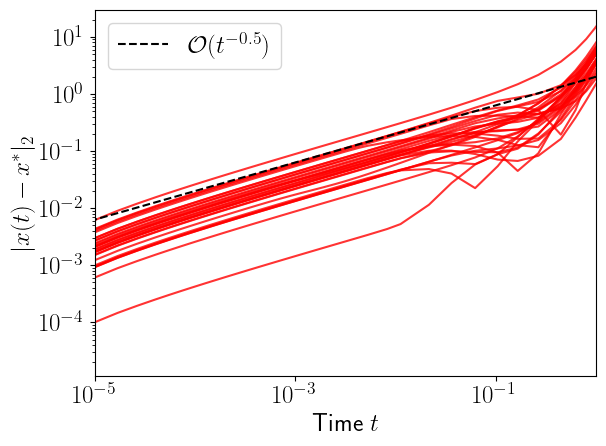

In [39]:
ctr = 1
res_loc = torch.tensor(GMM_x, device=latents.device, dtype=torch.float32).reshape(lat_shape)

plt.figure()
for i in range(batch_size):
    # compute distance to final point
    res_i = res_loc[i,:,:]
    dist = torch.sqrt(torch.sum((res_i - res_i[:,-1][:,np.newaxis])**2, axis=0))
    plt.loglog(GMM_t, dist, '-r', alpha=0.8)
plt.loglog(GMM_t, 2*(GMM_t)**0.5, '--k', label = '$\mathcal{O}(t^{-0.5})$')
plt.xlabel('Time $t$')
plt.ylabel('$|x(t) - x^*|_2$')
plt.legend()
plt.xlim(1e-5,1)
plt.tight_layout()
plt.savefig('exponential_convergence.pdf')
plt.show()